# Personalized Product Recommendations Using Rank-Based Algorithms for E-Commerce Platforms

### Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

## Importing Dataset

In [2]:
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

### 📊 EDA - Exploratory Data Analysis  

Before proceeding with modeling, we need to understand the structure and quality of our dataset through **Exploratory Data Analysis (EDA)**.  

### Key Checks:  
✅ **Dataset Overview:**  
- **Shape**: Check the number of rows and columns.  
- **Data Types**: Ensure that all columns are in the correct format.  
- **Missing Values**: Identify and handle any missing data.  

✅ **Dataset Summary:**  
- **Rating Distribution**: Analyze how ratings are distributed among users.  
- **Number of Users & Products**: Count the unique users and products in the dataset.  
- **Users with the Most Ratings**: Identify the most active users who have given the highest number of ratings.  

This analysis helps us **detect data quality issues, uncover patterns, and prepare the dataset for further processing**.  


### Shape

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


### Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### Missing value analysis

In [5]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### Summary

In [6]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Rating distribution

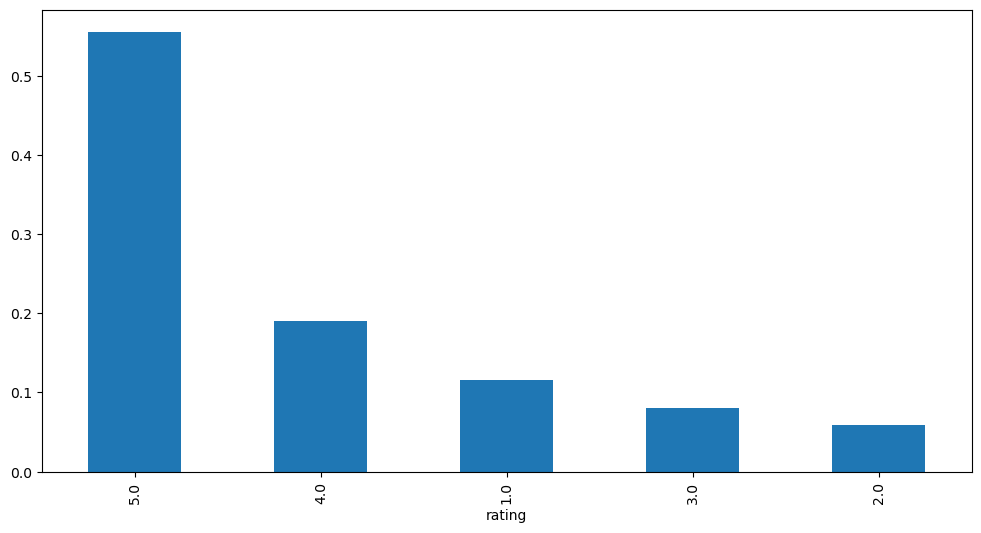

In [7]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

### ⭐ Rating Distribution Analysis  

The **rating distribution is right-skewed**, indicating that users tend to give higher ratings.  

- **More than 50%** of the ratings are **5 stars**, making it the most frequent rating.  
- **Around 20%** of the ratings are **4 stars**, showing a strong preference for positive feedback.  
- The percentage of ratings **gradually decreases** as the rating value decreases.  
- **Less than 10%** of the ratings are **2 stars**, indicating that low ratings are relatively rare.  

This distribution suggests a general **positive bias** in user ratings, which may influence recommendation modeling.


### No of unique users and items

In [8]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### Users with most no of rating

In [9]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

### 🔄 Pre-Processing  

To make the dataset **less sparse** and more manageable, we will **filter out users who have given fewer than 50 ratings**.  

### Why This Step?  
✔ **Reduces sparsity**, making the dataset more structured.  
✔ **Enhances computational efficiency** by focusing on active users.  
✔ **Improves recommendation quality** by ensuring sufficient user interactions.  

By keeping only users with **50 or more ratings**, we retain valuable information while optimizing the dataset for better performance in modeling.


In [10]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [11]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [12]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System 

In [14]:
average_rating = df_final.groupby('prod_id')['rating'].mean()
count_rating = df_final.groupby('prod_id')['rating'].count()

final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

print(final_rating.head())


            avg_rating  rating_count
prod_id                             
0594451647         5.0             1
B003RRY9RS         5.0             1
B003RR95Q8         5.0             1
B003RIPMZU         5.0             1
B003RFRNYQ         5.0             2


In [15]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [16]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

## Recommending top 5 products with 100 minimum interactions based on popularity

In [17]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']